# News Topic Classifier Using BERT
## Objective:
Fine-tune a transformer model (e.g., BERT) to classify news headlines into topic categories.
## Dataset:
AG News Dataset (Available on Hugging Face Datasets)

In [1]:
!pip install transformers datasets torch scikit-learn pyngrok


In [2]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 96.8 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
#from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, f1_score
from pyngrok import ngrok
import os
import streamlit as st

In [4]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

In [5]:
# Load the AG News dataset
dataset = load_dataset("ag_news")

# Check the first few examples
print(dataset['train'][0])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


In [7]:
# Load DistilBERT tokenizer and model (smaller than BERT, so faster)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Tokenize train and test datasets
train_dataset = dataset['train'].map(tokenize_function, batched=True)
test_dataset = dataset['test'].map(tokenize_function, batched=True)

# Set training arguments for faster training
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,              # Reduce to 1 epoch
    per_device_train_batch_size=4,   # Reduce batch size
    per_device_eval_batch_size=8,    # Reduce batch size
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    # evaluation_strategy="steps",     # Evaluate after a fixed number of steps
    # eval_steps=500                   # Evaluate after 500 steps
)

# Compute metrics
def compute_metrics(p):
    preds = p.predictions.argmax(axis=-1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose "Don't visualize my results"


Step,Training Loss
10,1.394000
20,1.417700
30,1.376500
40,1.373900
50,1.377000
60,1.335700
70,1.346700
80,1.345100
90,1.300600
100,1.237600


Step,Training Loss
10,1.394000
20,1.417700
30,1.376500
40,1.373900
50,1.377000
60,1.335700
70,1.346700
80,1.345100
90,1.300600
100,1.237600


TrainOutput(global_step=30000, training_loss=0.3356679804800699, metrics={'train_runtime': 7096.3234, 'train_samples_per_second': 16.91, 'train_steps_per_second': 4.228, 'total_flos': 1.589665480704e+16, 'train_loss': 0.3356679804800699, 'epoch': 1.0})

In [8]:
# Evaluate the model
results = trainer.evaluate()

# Display the evaluation metrics
print(f"Accuracy: {results['eval_accuracy']}")
print(f"F1-Score: {results['eval_f1']}")


Accuracy: 0.9401315789473684
F1-Score: 0.9401344474169023


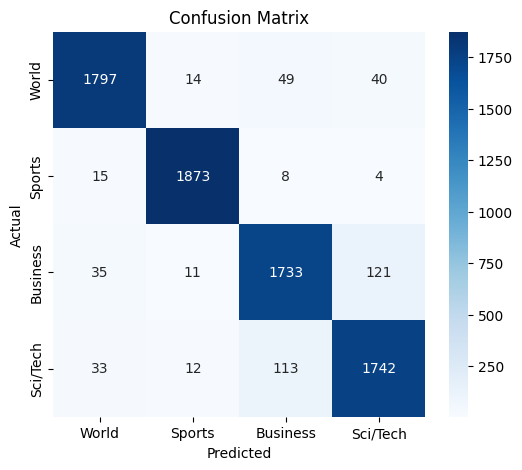

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix

predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["World","Sports","Business","Sci/Tech"],
            yticklabels=["World","Sports","Business","Sci/Tech"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [11]:
model.save_pretrained("news_bert_model")
tokenizer.save_pretrained("news_bert_model")

('news_bert_model/tokenizer_config.json',
 'news_bert_model/special_tokens_map.json',
 'news_bert_model/vocab.txt',
 'news_bert_model/added_tokens.json')

In [20]:
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model="news_bert_model",
    tokenizer="news_bert_model"
)

test_text = "Apple releases a new AI-powered iPhone"
classifier(test_text)


Device set to use cuda:0


[{'label': 'LABEL_3', 'score': 0.9979526996612549}]

In [19]:
def predict_topic(text):
    result = classifier(text)[0]
    return result["label"], round(result["score"], 3)

predict_topic("NASA launches new satellite into orbit")


('LABEL_3', 0.998)

In [18]:
label_map = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

def predict_topic(text):
    result = classifier(text)[0]
    label_id = int(result["label"].split("_")[-1])
    return label_map[label_id], round(result["score"], 3)

predict_topic("Microsoft launches new AI product")

('Sci/Tech', 0.993)

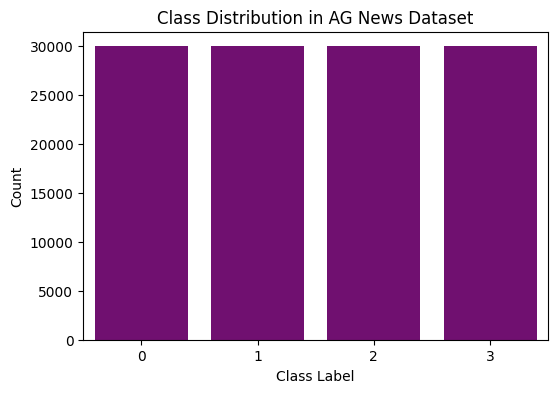

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = dataset["train"]["label"]

plt.figure(figsize=(6,4))
sns.countplot(x=labels, color="purple")
plt.title("Class Distribution in AG News Dataset")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()


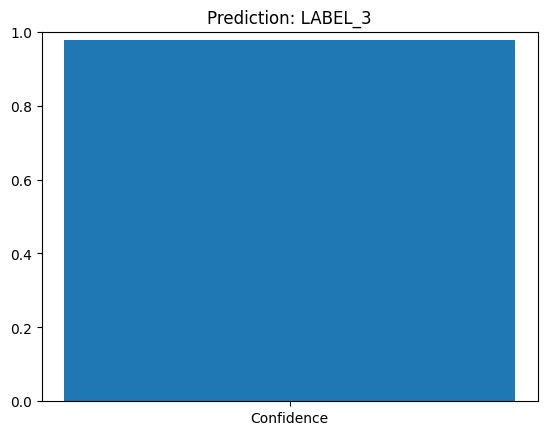

In [17]:
sample = "Google announces new AI model for healthcare"
output = classifier(sample)[0]

plt.bar(["Confidence"], [output["score"]])
plt.ylim(0,1)
plt.title(f"Prediction: {output['label']}")
plt.show()


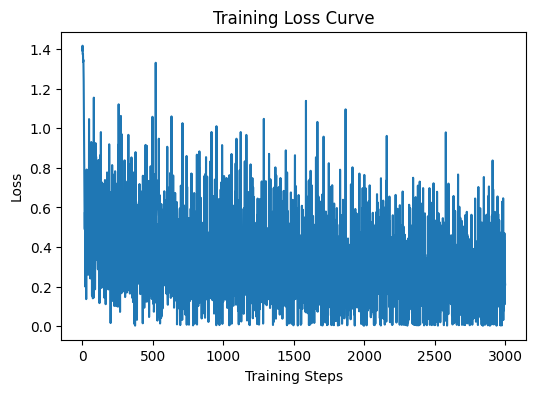

In [15]:
logs = trainer.state.log_history

losses = [log["loss"] for log in logs if "loss" in log]
steps = range(len(losses))

plt.figure(figsize=(6,4))
plt.plot(steps, losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()